
# Developing Neural Network Models to Predict Trends in Dublin's Rental Property Market

This notebook is part of a thesis work aimed at developing neural network models, specifically Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks, to predict trends in Dublin's rental property market. The dataset used in this analysis is titled "RTB Average Monthly Rent Report" and contains rental data across various locations, property types, and years in Ireland.

Link: https://data.cso.ie/table/RIA02

### Dataset Overview
The dataset consists of the following columns:
- `STATISTIC Label`: Describes the statistical data (in this case, always "RTB Average Monthly Rent Report").
- `Year`: The year when the data was recorded.
- `Number of Bedrooms`: Number of bedrooms in the rental property.
- `Property Type`: The type of rental property.
- `Location`: The location of the property.
- `UNIT`: The unit of the rental value (Euro).
- `VALUE`: The average monthly rent in Euros.

The data includes 299,712 rows and 7 columns. It is important to note that the `VALUE` column contains missing values that need to be handled during data preprocessing.

# 1. Data 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings  # filter warnings
warnings.filterwarnings('ignore')

# Loading the dataset
df = pd.read_csv('RTB Average Monthly Rent Report.csv')
df.head()

,STATISTIC Label,Year,Number of Bedrooms,Property Type,Location,UNIT,VALUE
0,RTB Average Monthly Rent Report,2008,All bedrooms,All property types,Carlow,Euro,748.48
1,RTB Average Monthly Rent Report,2008,All bedrooms,All property types,Carlow Town,Euro,811.53
2,RTB Average Monthly Rent Report,2008,All bedrooms,All property types,"Graiguecullen, Carlow",Euro,711.35
3,RTB Average Monthly Rent Report,2008,All bedrooms,All property types,"Tullow, Carlow",Euro,720.04
4,RTB Average Monthly Rent Report,2008,All bedrooms,All property types,Cavan,Euro,571.72


In [2]:
print(df.shape)

(299712, 7)


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   STATISTIC Label     299712 non-null  object 
 1   Year                299712 non-null  int64  
 2   Number of Bedrooms  299712 non-null  object 
 3   Property Type       299712 non-null  object 
 4   Location            299712 non-null  object 
 5   UNIT                299712 non-null  object 
 6   VALUE               104665 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 16.0+ MB
None


# 2. Exploratory Data Analysis

### Checking for missing values

In [4]:
## Missing Data Analysis

# Checking for missing values
missing_values = df.isnull().sum()
missing_values

STATISTIC Label            0
Year                       0
Number of Bedrooms         0
Property Type              0
Location                   0
UNIT                       0
VALUE                 195047
dtype: int64

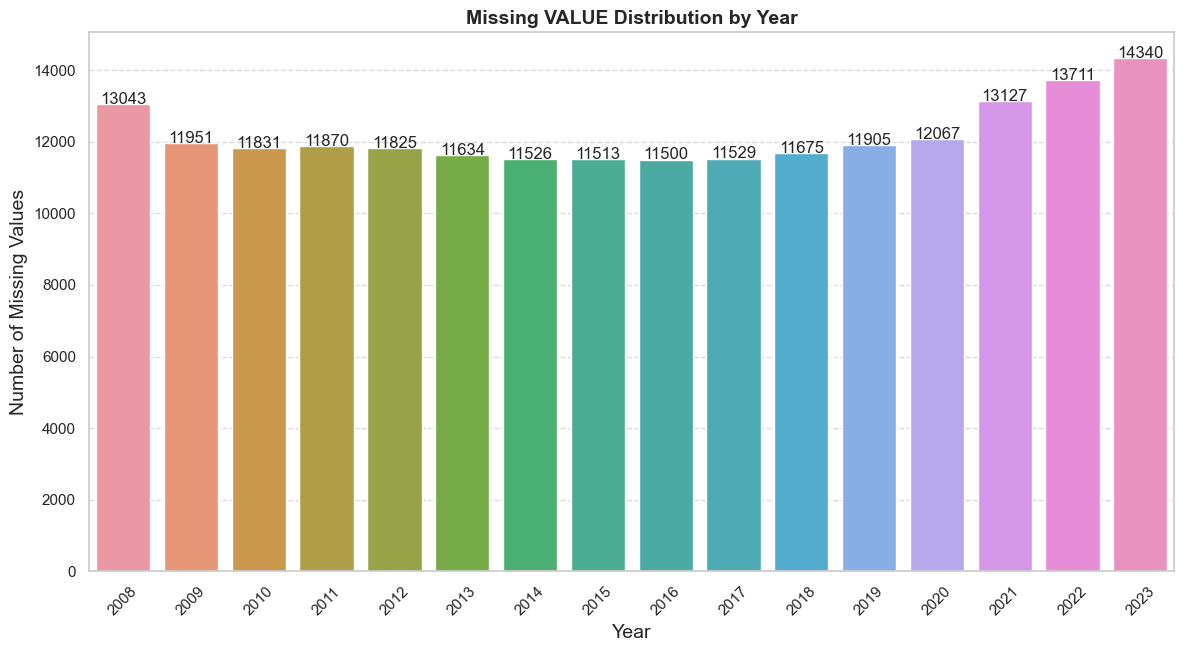

In [5]:
# Visualizing missing data distribution by Year with enhanced style
missing_distribution = df[df['VALUE'].isnull()]['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.barplot(x=missing_distribution.index, y=missing_distribution.values)

# Adding values on top of bars
for index, value in enumerate(missing_distribution.values):
    plt.text(index, value + 5, f'{value}', ha='center', fontsize=12)

plt.title('Missing VALUE Distribution by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [8]:
# Creating a copy of the original dataframe
df1 = df.copy()

# Step 1: Impute missing values with the mean of each combination of Year and Location
df1['VALUE'] = df1.groupby(['Year', 'Location'])['VALUE'].transform(lambda x: x.fillna(x.mean()))

# Step 2: Check if there are still missing values after the first imputation
missing_after_first_step = df1['VALUE'].isnull().sum()
print(f"Missing values after imputing by Year and Location: {missing_after_first_step}")

# Step 3: If there are still missing values, impute with the annual mean (Year only)
df1['VALUE'] = df1.groupby('Year')['VALUE'].transform(lambda x: x.fillna(x.mean()))

# Step 4: Check if there are still missing values after imputing by year
missing_after_second_step = df1['VALUE'].isnull().sum()
print(f"Missing values after imputing by Year: {missing_after_second_step}")

# Step 5: If there are still missing values, fill with the overall median
if missing_after_second_step > 0:
    overall_median = df1['VALUE'].median()
    df1['VALUE'].fillna(overall_median, inplace=True)

# Final check to ensure all missing values have been imputed
missing_after_final_step = df1['VALUE'].isnull().sum()
print(f"Missing values after all imputations: {missing_after_final_step}")


Missing values after imputing by Year and Location: 17514
Missing values after imputing by Year: 0
Missing values after all imputations: 0


### Checking for Infinite Values in a DataFrame

In [9]:
import numpy as np

# Replace infinite values with NaN temporarily to count them
def check_infinite_values(df):
    # Temporarily replace infinities with NaN
    inf_count = df.replace([np.inf, -np.inf], np.nan).isna().sum()
    
    # Filter out columns with no infinite values
    inf_count = inf_count[inf_count > 0]
    
    # Display the columns with infinite values and their respective counts
    if not inf_count.empty:
        print("Columns with infinite values and their counts:")
        print(inf_count)
    else:
        print("No infinite values found in the DataFrame.")

# Call the function to check for infinite values in df1
check_infinite_values(df1)


No infinite values found in the DataFrame.


###  Check for duplicate rows

In [10]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Optionally, display the duplicate rows
duplicates = df[df.duplicated()]
print(duplicates)

Number of duplicate rows: 0
Empty DataFrame
Columns: [STATISTIC Label, Year, Number of Bedrooms, Property Type, Location, UNIT, VALUE]
Index: []


In [11]:
# Check which rows have NaN in the 'VALUE' column
nan_rows = df1[df1['VALUE'].isna()]
print(nan_rows.head())  # Display the first few rows with NaN in 'VALUE'

Empty DataFrame
Columns: [STATISTIC Label, Year, Number of Bedrooms, Property Type, Location, UNIT, VALUE]
Index: []


### Detect outliers using the IQR method with adjusted multiplier

In [50]:
# Detect outliers using the IQR method with adjusted multiplier
def detect_outliers_iqr_adjusted(df, column, multiplier=3):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers with multiplier {multiplier}: {len(outliers)}")
    
    # Return the bounds and outliers
    return outliers, lower_bound, upper_bound

# Apply the function and retain outliers
outliers_iqr_adjusted, lower_bound, upper_bound = detect_outliers_iqr_adjusted(df1, 'VALUE', multiplier=3)

# Justify keeping high-value outliers
print(f"Outliers found above the upper bound ({upper_bound}) are justified as high-value properties and will be kept in the dataset.")

# Examples of high-value outliers
high_value_outliers = outliers_iqr_adjusted[outliers_iqr_adjusted['VALUE'] > upper_bound]
print("Examples of high-value outliers that will be retained:")
print(high_value_outliers.head(10))

# Final dataset including outliers, named as df2
df2 = df1.copy()

# Confirm the dataset is ready for further analysis
print("The dataset has been defined as df2 and is ready for further analysis.")


Number of outliers with multiplier 3: 352
Outliers found above the upper bound (3113.465000000001) are justified as high-value properties and will be kept in the dataset.
Examples of high-value outliers that will be retained:
                        STATISTIC Label  Year Number of Bedrooms  \
72352   RTB Average Monthly Rent Report  2011      Four plus bed   
74135   RTB Average Monthly Rent Report  2011      Four plus bed   
74136   RTB Average Monthly Rent Report  2011      Four plus bed   
91084   RTB Average Monthly Rent Report  2012      Four plus bed   
92633   RTB Average Monthly Rent Report  2012      Four plus bed   
92867   RTB Average Monthly Rent Report  2012      Four plus bed   
92868   RTB Average Monthly Rent Report  2012      Four plus bed   
109816  RTB Average Monthly Rent Report  2013      Four plus bed   
111600  RTB Average Monthly Rent Report  2013      Four plus bed   
114203  RTB Average Monthly Rent Report  2014       All bedrooms   

             Property Typ

### Visualize the outliers in the context of time (by year)

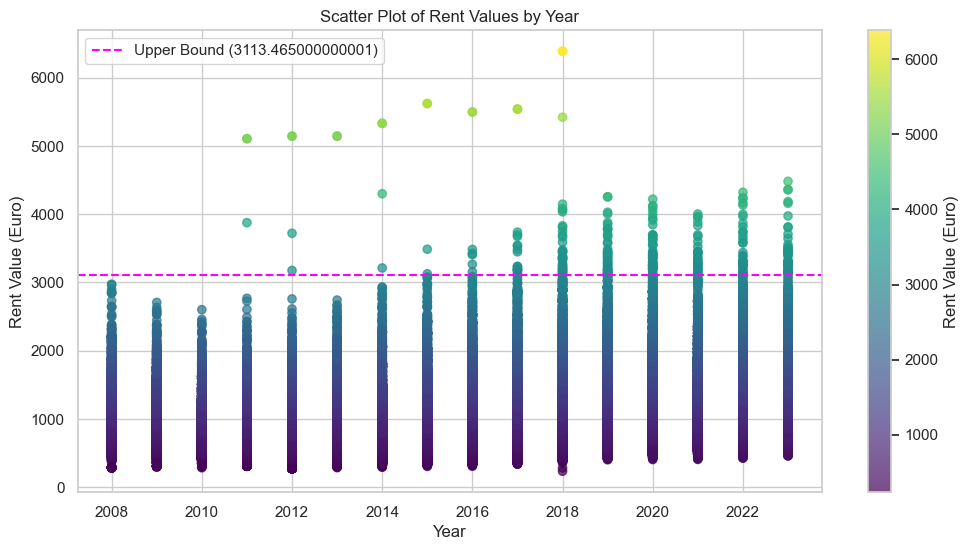

In [51]:
import numpy as np

plt.figure(figsize=(12, 6))

# Use a colormap for more colorful points based on the rent value
scatter = plt.scatter(df2['Year'], df2['VALUE'], c=df2['VALUE'], cmap='viridis', alpha=0.7)

# Add a color bar for reference
plt.colorbar(scatter, label='Rent Value (Euro)')

# Titles and labels
plt.title('Scatter Plot of Rent Values by Year')
plt.xlabel('Year')
plt.ylabel('Rent Value (Euro)')

# Highlight the upper bound for outliers
plt.axhline(y=upper_bound, color='magenta', linestyle='--', label=f'Upper Bound ({upper_bound})')

plt.legend()
plt.show()

## 3. Data Visualization

### Trends over Years

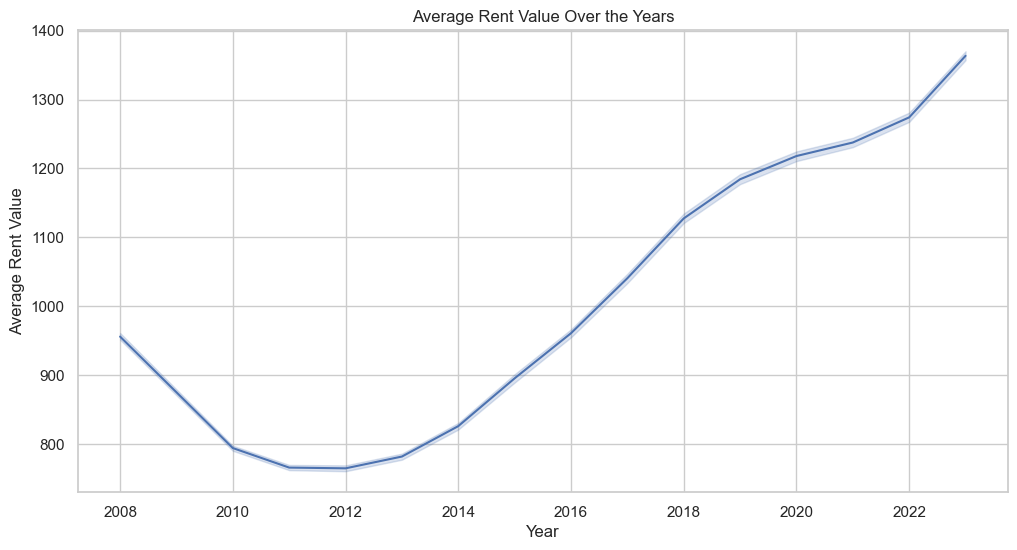

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trends over Years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df2, x='Year', y='VALUE')
plt.title('Average Rent Value Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rent Value')
plt.grid(True)
plt.show()

### Rent Values by Top 10 Locations

In [59]:
import plotly.express as px

# Rent Values by Top 10 Locations
top_locations = df2['Location'].value_counts().nlargest(10).index
filtered_data = df2[df2['Location'].isin(top_locations)]
fig = px.box(filtered_data, x='Location', y='VALUE', color='Location', title='Rent Values by Top 10 Locations')
fig.update_xaxes(categoryorder='total descending')
fig.show()

### Identify the top cities

In [60]:
# Identify the top cities (excluding Dublin)
top_cities = df2['Location'].value_counts().head(6).index  # Select the 6 most frequent cities
top_cities = top_cities[top_cities.str.contains('Dublin', case=False) == False]  # Exclude Dublin

# Add Dublin to the list of cities for comparison
top_cities = top_cities.insert(0, 'Dublin')

### Histograms for Dublin and the selected cities

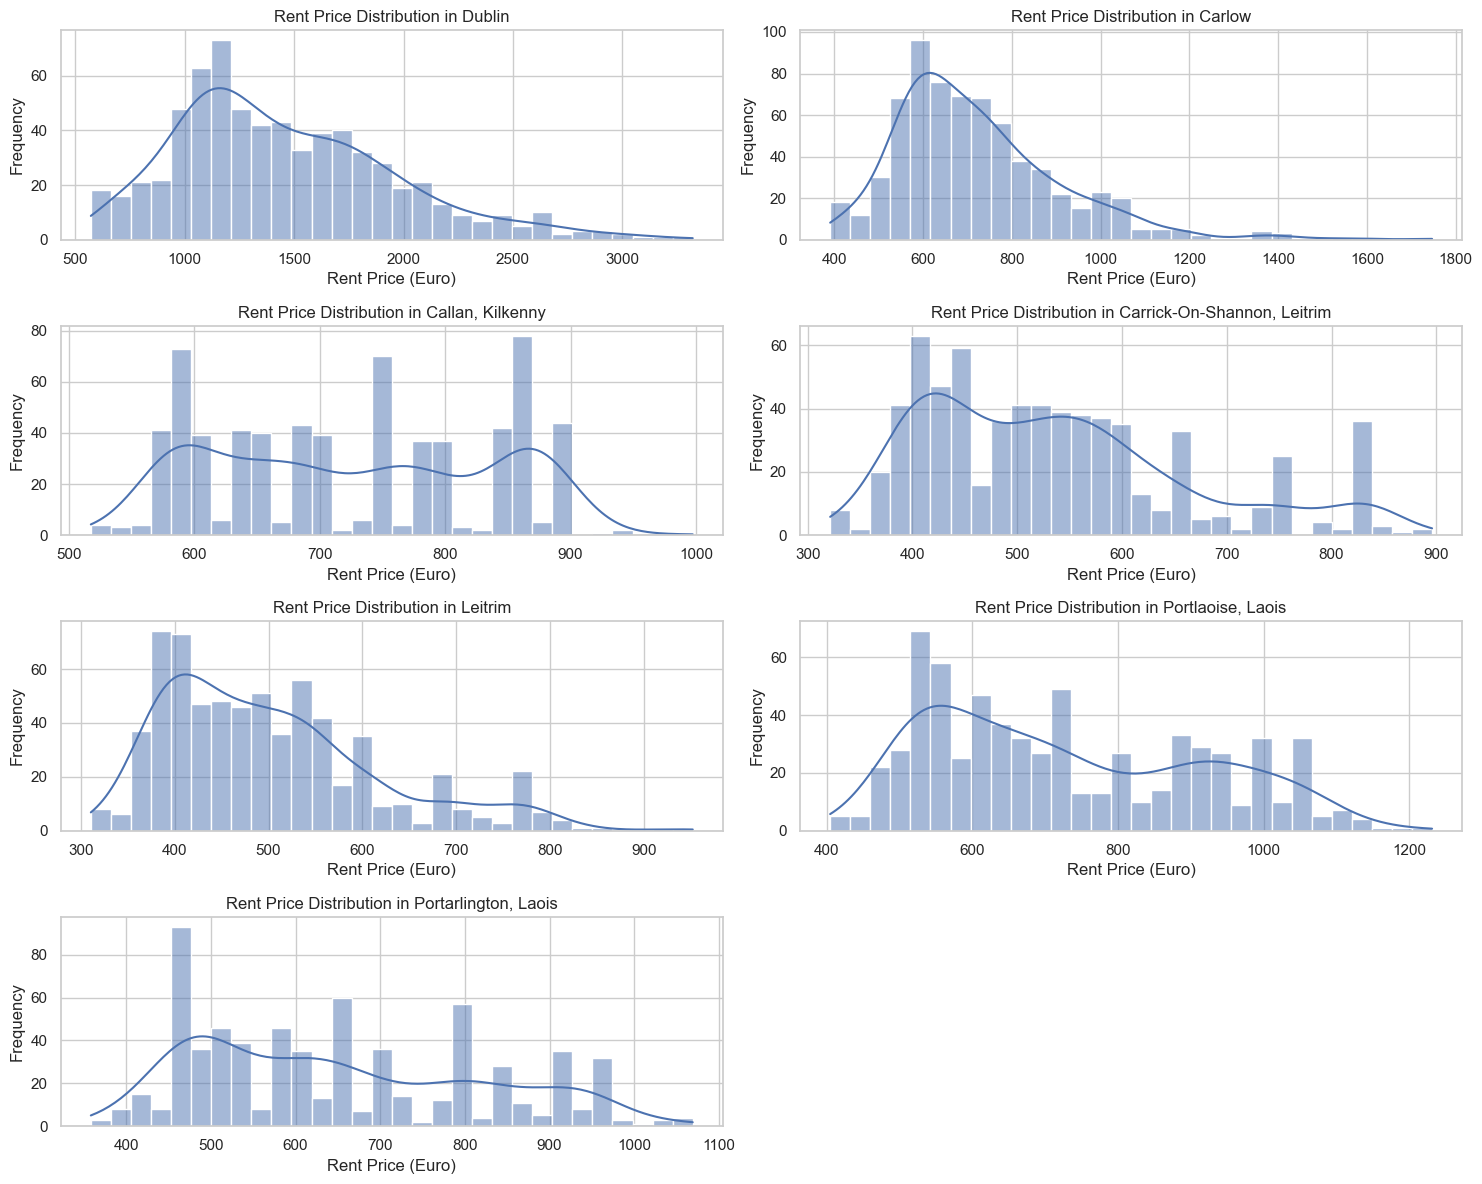

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to include only the selected cities
df_cities = df2[df2['Location'].isin(top_cities)]

# Plot histograms for Dublin and the selected cities
plt.figure(figsize=(15, 12))

for i, city in enumerate(top_cities):
    plt.subplot(4, 2, i + 1)  # Adjust the grid size based on the number of cities
    sns.histplot(df_cities[df_cities['Location'] == city]['VALUE'], kde=True, bins=30)
    plt.title(f'Rent Price Distribution in {city}')
    plt.xlabel('Rent Price (Euro)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Average Monthly Rent by Property Type in Ireland

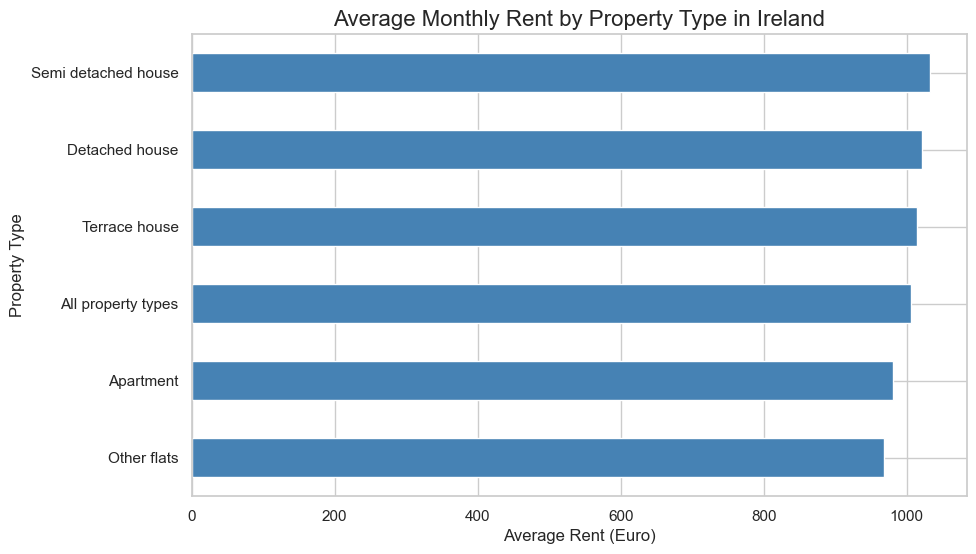

In [62]:
import matplotlib.pyplot as plt

# Grouping data by property type and calculating the average rent (VALUE)
average_rent_by_property = df2.groupby('Property Type')['VALUE'].mean().sort_values()

# Plotting the data
plt.figure(figsize=(10, 6))
average_rent_by_property.plot(kind='barh', color='steelblue')

# Adding titles and labels
plt.title('Average Monthly Rent by Property Type in Ireland', fontsize=16)
plt.xlabel('Average Rent (Euro)', fontsize=12)
plt.ylabel('Property Type', fontsize=12)

# Display the plot
plt.show()


### Average Monthly Rent by Number of Bedrooms

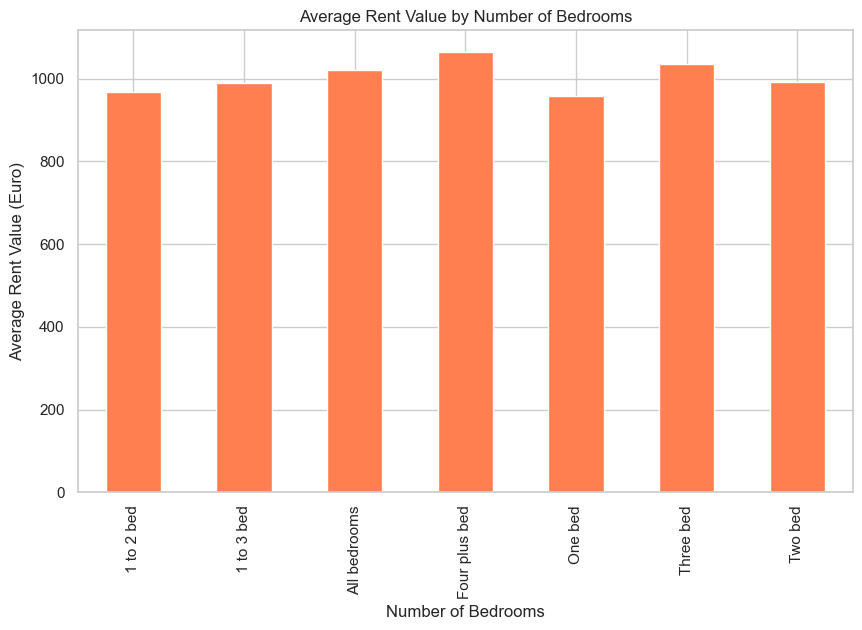

In [63]:
plt.figure(figsize=(10, 6))
df2.groupby('Number of Bedrooms')['VALUE'].mean().plot(kind='bar', color='coral')
plt.title('Average Rent Value by Number of Bedrooms')
plt.ylabel('Average Rent Value (Euro)')
plt.show()


# Dublin 

In [64]:
# Filter for rows where 'Location' contains 'Dublin' to create df3
df3 = df2[df2['Location'].str.contains('Dublin', case=False, na=False)]

# Show the first few rows of df3 to confirm the filtering
print(df3.head())

# Save df3 for future analysis and predictions
df3.to_csv('dublin_rental_data.csv', index=False)

print("Filtered dataset for Dublin saved as 'dublin_rental_data.csv'.")

                    STATISTIC Label  Year Number of Bedrooms  \
71  RTB Average Monthly Rent Report  2008       All bedrooms   
72  RTB Average Monthly Rent Report  2008       All bedrooms   
73  RTB Average Monthly Rent Report  2008       All bedrooms   
74  RTB Average Monthly Rent Report  2008       All bedrooms   
75  RTB Average Monthly Rent Report  2008       All bedrooms   

         Property Type             Location  UNIT        VALUE  
71  All property types               Dublin  Euro  1271.310000  
72  All property types   Balbriggan, Dublin  Euro  1033.330000  
73  All property types    Blackrock, Dublin  Euro  1587.100000  
74  All property types  Booterstown, Dublin  Euro  1656.820000  
75  All property types   Cabinteely, Dublin  Euro   955.819531  
Filtered dataset for Dublin saved as 'dublin_rental_data.csv'.


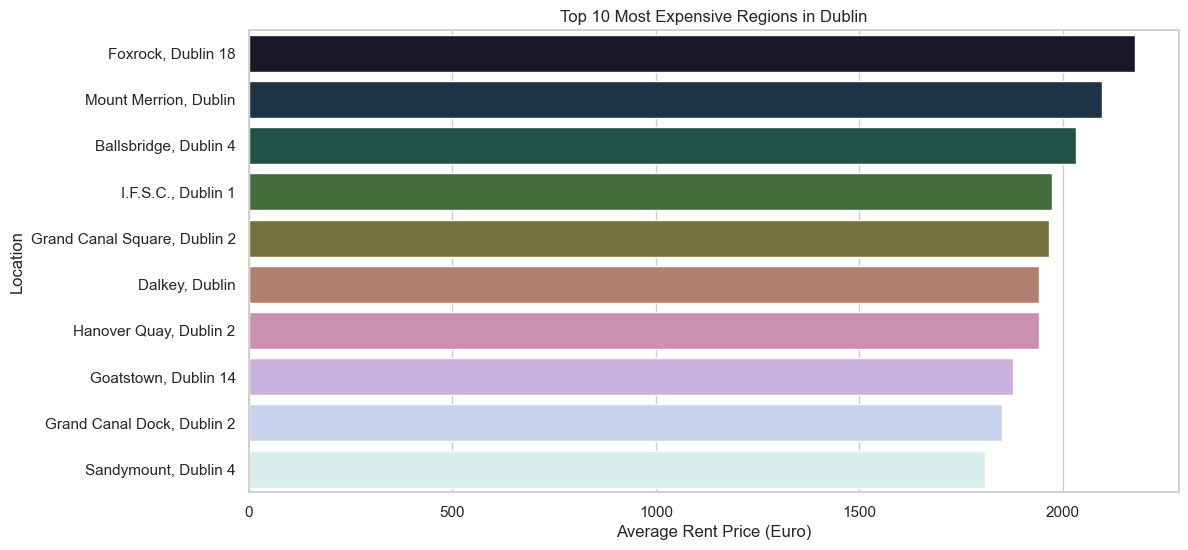

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean rent price per location in Dublin (using df3)
mean_rent_per_location = df3.groupby('Location')['VALUE'].mean().sort_values(ascending=False)

# Select the top 10 most expensive regions
top_10_expensive_locations = mean_rent_per_location.head(10)

# Plotting the top 10 most expensive locations with 'cubehelix' color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_expensive_locations.values, y=top_10_expensive_locations.index, palette='cubehelix')
plt.title('Top 10 Most Expensive Regions in Dublin')
plt.xlabel('Average Rent Price (Euro)')
plt.ylabel('Location')
plt.show()


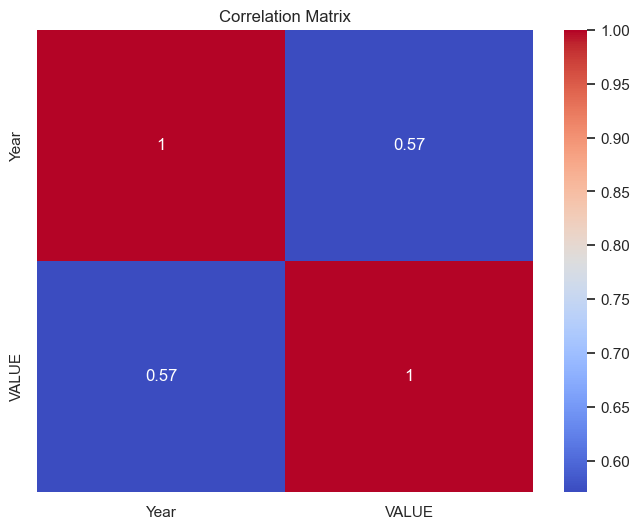

In [66]:
# Correlation matrix
corr_matrix = df3.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Dealing with Dublin's Outliers

In [72]:
# Function to detect outliers and return only the dataset without unwanted outliers
def remove_outliers_iqr_adjusted(df3, column, multiplier=3):
    Q1 = df3[column].quantile(0.25)
    Q3 = df3[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find all outliers
    outliers = df3[(df3[column] < lower_bound) | (df3[column] > upper_bound)]
    print(f"Number of outliers with multiplier {multiplier}: {len(outliers)}")

    # Retain only high-value outliers (above the upper bound)
    df_cleaned = df3[(df3[column] >= lower_bound) & (df3[column] <= upper_bound) | (df3[column] > upper_bound)]
    
    # Return cleaned dataset and the bounds
    return df_cleaned, lower_bound, upper_bound

# Apply the function to remove the unwanted outliers and save the result in df3
df3, lower_bound, upper_bound = remove_outliers_iqr_adjusted(df3, 'VALUE', multiplier=3)

# Show the dataset after removing the unwanted outliers
print("Dataset after removing unwanted outliers:")
print(df3.head())

# Save the updated df3 if necessary
df3.to_csv('updated_dublin_rental_data.csv', index=False)
print("Updated dataset saved as 'updated_dublin_rental_data.csv'.")


Number of outliers with multiplier 3: 218
Dataset after removing unwanted outliers:
                    STATISTIC Label  Year Number of Bedrooms  \
71  RTB Average Monthly Rent Report  2008       All bedrooms   
72  RTB Average Monthly Rent Report  2008       All bedrooms   
73  RTB Average Monthly Rent Report  2008       All bedrooms   
74  RTB Average Monthly Rent Report  2008       All bedrooms   
75  RTB Average Monthly Rent Report  2008       All bedrooms   

         Property Type             Location  UNIT        VALUE  
71  All property types               Dublin  Euro  1271.310000  
72  All property types   Balbriggan, Dublin  Euro  1033.330000  
73  All property types    Blackrock, Dublin  Euro  1587.100000  
74  All property types  Booterstown, Dublin  Euro  1656.820000  
75  All property types   Cabinteely, Dublin  Euro   955.819531  
Updated dataset saved as 'updated_dublin_rental_data.csv'.


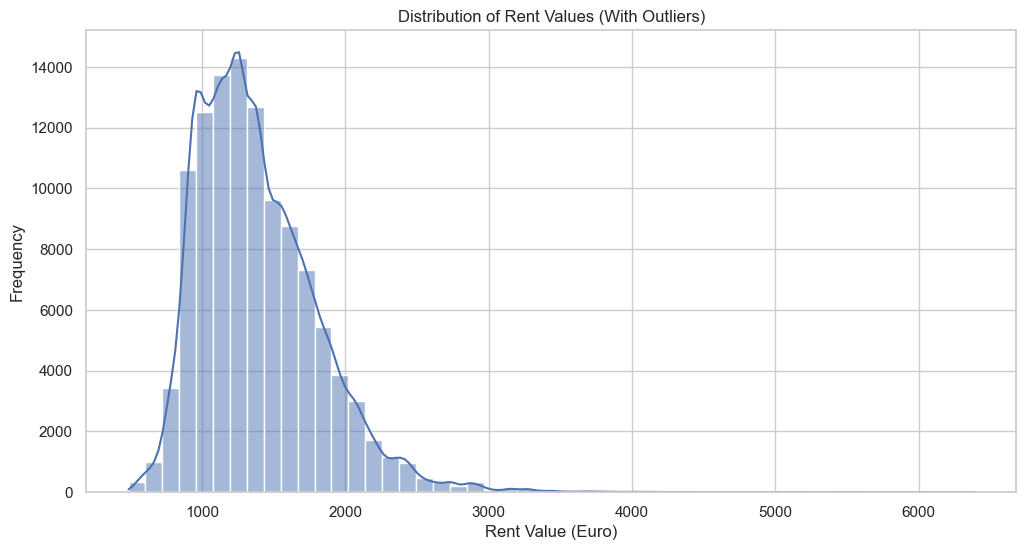

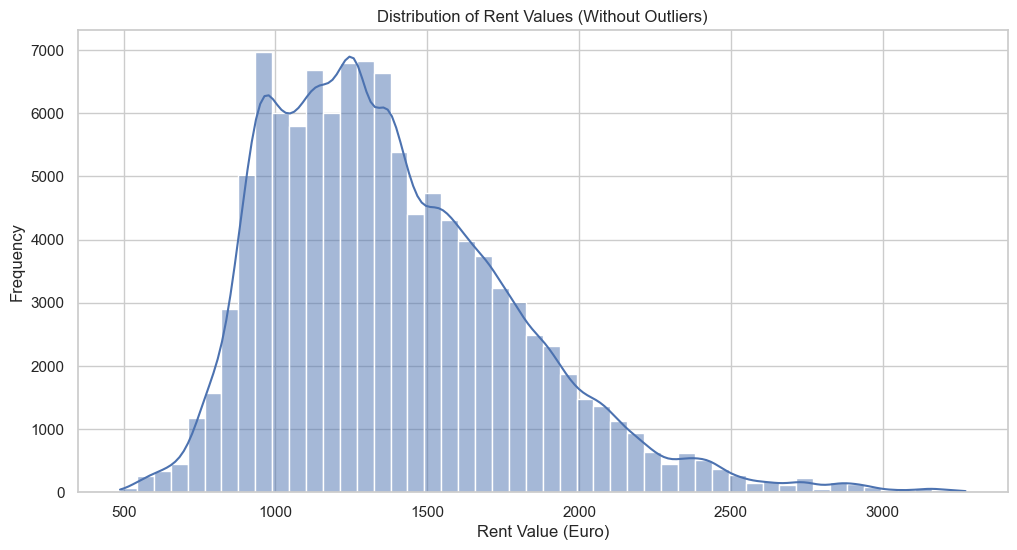

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of rent values with outliers
plt.figure(figsize=(12,6))
sns.histplot(df3['VALUE'], bins=50, kde=True)
plt.title('Distribution of Rent Values (With Outliers)')
plt.xlabel('Rent Value (Euro)')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of rent values without outliers
df_no_outliers = df3[df3['VALUE'] <= upper_bound]

plt.figure(figsize=(12,6))
sns.histplot(df_no_outliers['VALUE'], bins=50, kde=True)
plt.title('Distribution of Rent Values (Without Outliers)')
plt.xlabel('Rent Value (Euro)')
plt.ylabel('Frequency')
plt.show()


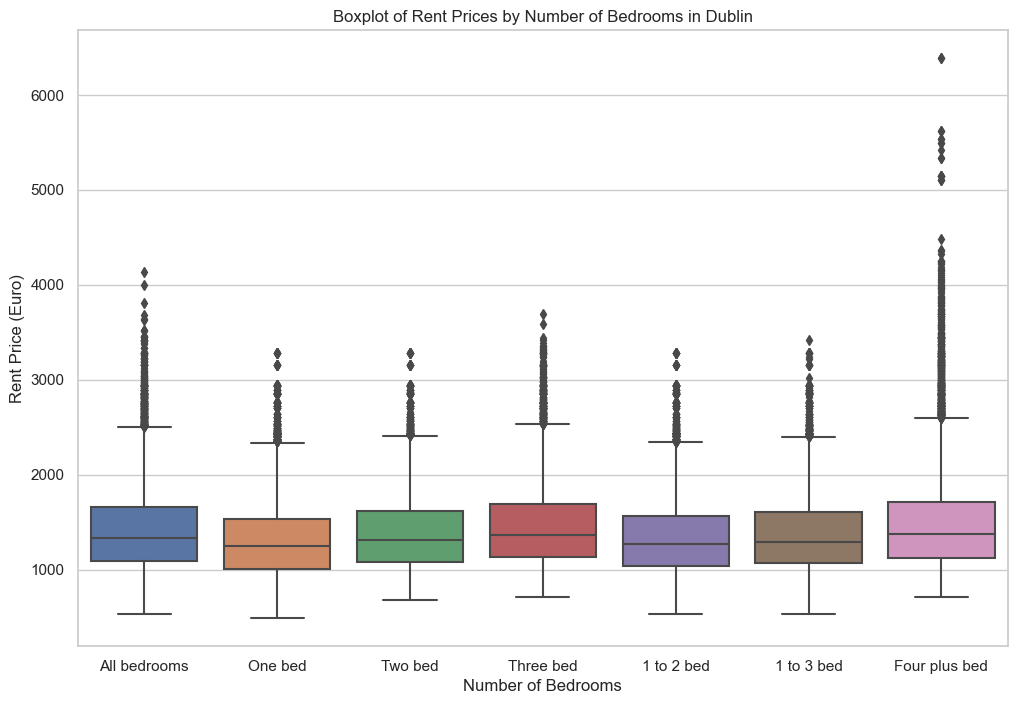

In [74]:
# Boxplot to detect outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df3, x='Number of Bedrooms', y='VALUE')
plt.title('Boxplot of Rent Prices by Number of Bedrooms in Dublin')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Rent Price (Euro)')
plt.show()

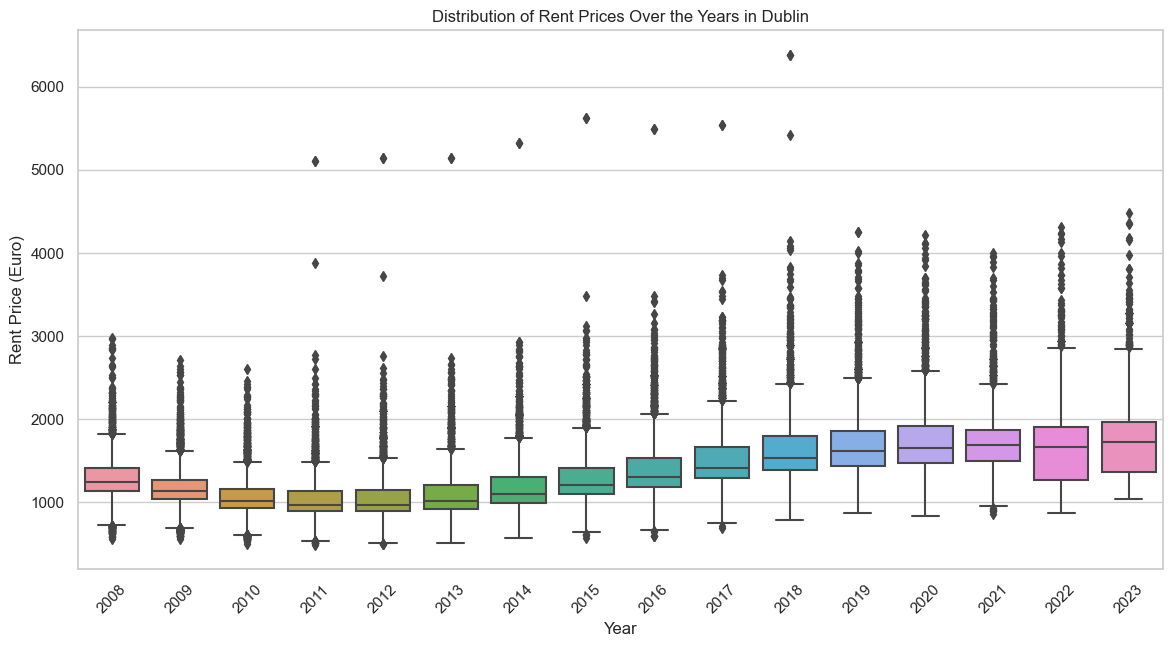

In [75]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='Year', y='VALUE', data=df3)
plt.title('Distribution of Rent Prices Over the Years in Dublin')
plt.xlabel('Year')
plt.ylabel('Rent Price (Euro)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# 4. Statistical Analysis of Stability and Temporal Dependence in the Rental Market.

### Dickey-Fuller test

In [76]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(df3['VALUE'].dropna())

# Extract and display results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')



ADF Statistic: -9.70913351962796
p-value: 1.0227134670109034e-16
Critical Value (1%): -3.4304083082902537
Critical Value (5%): -2.861565771381552
Critical Value (10%): -2.566783717199238


### Autocorrelation (ACF) and Partial Autocorrelation (PACF) Correlation Test

<Figure size 1000x600 with 0 Axes>

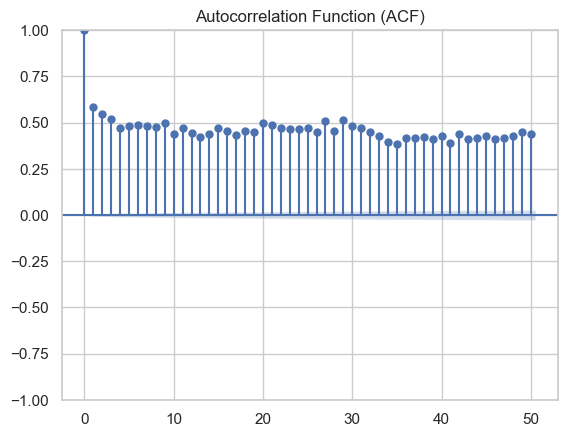

<Figure size 1000x600 with 0 Axes>

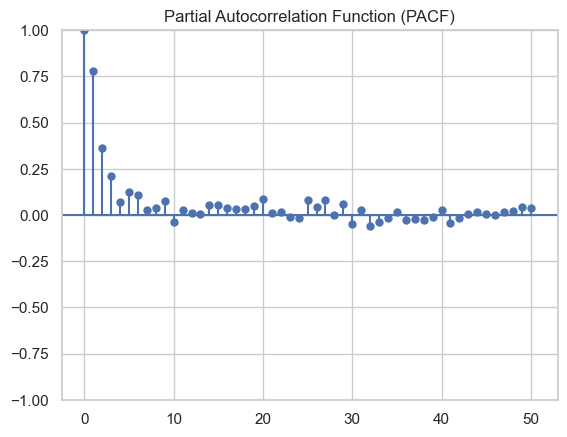

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(10, 6))
plot_acf(df3['VALUE'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 6))
plot_pacf(df2['VALUE'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


### 2. Spearman correlation

In [78]:
from scipy import stats

# Spearman correlation between Year and Rent Value
spearman_corr, p_value = stats.spearmanr(df3['Year'], df3['VALUE'])

print('Spearman correlation between Year and Rent Value:', spearman_corr)
print('P-value:', p_value)

Spearman correlation between Year and Rent Value: 0.6209940266823573
P-value: 0.0


### 3. Heteroscedasticity Test (Breusch-Pagan Test)
For time series data, it is important to verify if the variance is constant over time. Heteroscedasticity occurs when the variance changes over time, which can complicate modeling.

Code for the Breusch-Pagan test:

In [79]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols

# Simple regression for the test
model = ols('VALUE ~ Year', data=df3).fit()
test_result = het_breuschpagan(model.resid, model.model.exog)

# Display results
print('Breusch-Pagan Test Statistic:', test_result[0])
print('p-value:', test_result[1])


Breusch-Pagan Test Statistic: 614.3277796072759
p-value: 1.2807180020420195e-135


In [80]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
stat, p_value = shapiro(df3['VALUE'].dropna())

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)


Shapiro-Wilk Statistic: 0.938151478767395
p-value: 0.0


1. Dickey-Fuller Test (ADF)
Resultado: ADF Statistic: -9.709, p-value: 1.02e-16
Interpretação:
O valor da estatística ADF é significativamente menor que todos os valores críticos (1%, 5% e 10%), o que indica que podemos rejeitar a hipótese nula de que há uma raiz unitária. Isso sugere que a série de tempo é estacionária.
Como o p-valor é muito baixo, temos uma forte evidência de que a série temporal de preços de aluguel não contém uma raiz unitária e é estacionária, o que é uma boa característica para a modelagem com RNN ou LSTM.
2. Autocorrelation (ACF) and Partial Autocorrelation (PACF)
ACF: A função de autocorrelação mostra a relação entre um valor de uma série temporal com seus próprios lags. Se os gráficos de ACF mostram uma cauda longa, pode indicar que os dados não são totalmente estacionários (apesar de o Dickey-Fuller ter indicado que sim).
PACF: A função de autocorrelação parcial mostra a relação entre a série temporal e um determinado lag, removendo a influência dos lags anteriores. Isso ajuda a identificar quais lags são importantes. Se o gráfico PACF mostrar uma queda rápida após um ou dois lags, é possível que apenas esses lags sejam suficientes para capturar a dependência temporal.
Com base nos gráficos, devemos selecionar os lags mais relevantes e considerar isso na modelagem, especialmente no caso de modelos de RNN e LSTM.

3. Spearman Correlation
Correlação de Spearman entre Ano e Valor do Aluguel: 0.621
P-valor: 0.0
Interpretação:
A correlação de Spearman é uma medida não paramétrica de dependência entre duas variáveis. O valor de 0.621 indica uma correlação positiva moderada entre o ano e os valores de aluguel. O p-valor muito baixo (0.0) sugere que essa correlação é estatisticamente significativa.
Isso indica que existe uma tendência crescente dos preços de aluguel ao longo dos anos, o que pode ser um fator importante para incluir na modelagem.
4. Breusch-Pagan Test (Heteroscedasticity Test)
Resultado: Test Statistic: 614.32, p-value: 1.28e-135
Interpretação:
O p-valor muito baixo sugere que existe heterocedasticidade significativa nos dados. Isso significa que a variância dos resíduos muda ao longo do tempo, o que pode complicar a modelagem, já que muitos modelos assumem homocedasticidade (variância constante).
Neste caso, pode ser útil considerar transformações nos dados ou usar técnicas robustas para heterocedasticidade (como o uso de camadas de dropout ou ajustes na normalização).
5. Shapiro-Wilk Test (Normality Test)
Shapiro-Wilk Statistic: 0.938, p-value: 0.0
Interpretação:
O p-valor muito baixo indica que podemos rejeitar a hipótese nula de que os dados seguem uma distribuição normal.
Isso sugere que os dados de valores de aluguel não são normalmente distribuídos, o que pode influenciar a escolha dos modelos e das métricas a serem usadas (por exemplo, o uso de RMSE e MAE, em vez de métricas baseadas na suposição de normalidade).



### 1. Data Transformation (Log Transform and Scaling)
Since we observed heteroscedasticity and non-normality, applying transformations such as log transformation and scaling could help stabilize variance and improve model performance.

# 5. Feature Engineering and Data Preparation

Abordagem Melhorada para Engenharia de Features:
Utilização de "Year" como Feature de Tendência:

O ano (Year) captura a tendência temporal de longo prazo. Em mercados como o de aluguéis, a tendência ao longo dos anos pode ser significativa.
Criação de Features Temporais Sazonais:

Adicionar features como o mês (caso a granularidade seja por mês) ou estação do ano pode capturar variações sazonais no mercado de aluguel.
Transformação de Variáveis:

Como você já utilizou a transformação logarítmica em VALUE (como log_VALUE), isso ajuda a estabilizar a variância em dados que podem crescer exponencialmente. Vamos manter essa abordagem.
Criação de Features de Diferença Percentual:

Em vez de usar lags diretos, podemos também criar diferenças percentuais entre os valores de aluguel de períodos consecutivos. Isso ajuda a modelar a variação em vez de apenas o valor bruto.
Encoders para Variáveis Categóricas (One-Hot Encoding):

Se existirem variáveis categóricas como localização ou tipo de imóvel, é importante transformá-las usando técnicas como o One-Hot Encoding.
Correção da Escala:

Escalar as features e o alvo é necessário para garantir que a LSTM converja corretamente durante o treinamento.
Agora, vou refazer a preparação dos dados seguindo esta abordagem.

Passos:
Criar features temporais (ex: Year, Month).
Transformar os valores de aluguel (log_VALUE).
Criar diferenciais entre períodos consecutivos em vez de apenas lags.
Preparar os dados para a LSTM.
Vamos implementar isso agora para você.

Aqui está a nova engenharia de features utilizando Year, Month (com codificação one-hot para capturar a sazonalidade), e também criamos mudanças percentuais (pct_change) para capturar variações nas séries temporais.

Resumo do que foi feito:
Features Temporais: Utilizamos o ano como uma feature contínua para capturar tendências ao longo do tempo. Também criamos uma codificação one-hot para o mês, que ajuda a modelar variações sazonais.
Mudança Percentual: Em vez de usar lags diretos, criamos as mudanças percentuais (pct_change1, pct_change2, pct_change3), que representam a variação percentual entre períodos consecutivos.
Transformação Logarítmica: Mantivemos a transformação logarítmica na variável VALUE para reduzir o efeito de valores extremos e estabilizar a variância.
Escalonamento e Preparação dos Dados: Os dados foram divididos em conjuntos de treino (80%) e teste (20%) e escalonados com MinMaxScaler. Também foram ajustados para o formato necessário para o treinamento de LSTM.
As formas dos dados para o treinamento da LSTM ficaram assim:

X_train: (397, 1, 15) — 397 amostras, 1 time step, 15 features.
y_train: (397,) — Alvo para as 397 amostras.
X_test: (100, 1, 15) — 100 amostras no conjunto de teste.


In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Simulating a dataset with 'Year' and 'VALUE' (assuming a larger dataset)
data = {
    'Year': np.random.randint(2000, 2021, size=500),  # Random years between 2000 and 2020
    'Month': np.random.randint(1, 13, size=500),  # Random months
    'VALUE': np.random.uniform(500, 2000, size=500),  # Random rental values between 500 and 2000
}

# Create a DataFrame
df3 = pd.DataFrame(data)

# Step 1: Add temporal features
# Let's add 'Month' as a categorical feature (using one-hot encoding)
df3 = pd.get_dummies(df3, columns=['Month'], drop_first=True)

# Step 2: Log-transform the 'VALUE' for target stabilization
df3['log_VALUE'] = np.log(df3['VALUE'])

# Step 3: Create percentage change (instead of direct lag features)
df3['pct_change1'] = df3['VALUE'].pct_change(periods=1)  # 1-period percentage change
df3['pct_change2'] = df3['VALUE'].pct_change(periods=2)  # 2-period percentage change
df3['pct_change3'] = df3['VALUE'].pct_change(periods=3)  # 3-period percentage change

# Drop any rows with NaN values (created by pct_change)
df3.dropna(inplace=True)

# Step 4: Define features and target
# We will use 'Year', 'Month' (as one-hot encoded), and percentage changes as features
features = ['Year'] + [col for col in df3.columns if col.startswith('Month')] + ['pct_change1', 'pct_change2', 'pct_change3']
target = 'log_VALUE'

# Step 5: Split the data into train and test sets (80% train, 20% test)
train_size = int(len(df3) * 0.8)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

# Step 6: Scale the features and the target
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])

# Step 7: Separate features and target for train and test sets
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

# Step 8: Reshape the data for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Output the shapes and head of the dataframe for confirmation
(X_train.shape, y_train.shape, X_test.shape, y_test.shape), df3.head()

(((397, 1, 15), (397,), (100, 1, 15), (100,)),
    Year        VALUE  Month_2  Month_3  Month_4  Month_5  Month_6  Month_7  \
 3  2004   551.666312        0        0        0        0        0        0   
 4  2010   631.470892        0        0        0        1        0        0   
 5  2007   992.589490        0        0        0        0        0        0   
 6  2006  1756.129386        0        0        0        0        0        0   
 7  2000  1165.568867        0        1        0        0        0        0   
 
    Month_8  Month_9  Month_10  Month_11  Month_12  log_VALUE  pct_change1  \
 3        1        0         0         0         0   6.312943    -0.579645   
 4        0        0         0         0         0   6.448052     0.144661   
 5        0        0         0         0         1   6.900317     0.571869   
 6        1        0         0         0         0   7.470867     0.769240   
 7        0        0         0         0         0   7.060965    -0.336285   
 
    pct

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Define the RNN model
model = Sequential()

# Add a SimpleRNN layer with 100 units and input shape (1 time step, 15 features)
model.add(SimpleRNN(100, activation='relu', input_shape=(1, 15)))

# Optionally add Dropout to reduce overfitting
model.add(Dropout(0.2))

# Add an output Dense layer with 1 unit (since we're predicting one value: 'log_VALUE')
model.add(Dense(1))

# Step 2: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Implement Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

# Step 5: Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/50
13/13 [==============================] - 1s 20ms/step - loss: 0.4208 - val_loss: 0.2354
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1689 - val_loss: 0.0809
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0819 - val_loss: 0.0481
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0680 - val_loss: 0.0410
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0573 - val_loss: 0.0369
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0511 - val_loss: 0.0346
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.0314
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0451 - val_loss: 0.0293
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0414 - val_loss: 0.0286
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0270
Epoch 11/50
13/13 

In [87]:
# Step 6: Generate predictions
y_pred = model.predict(X_test)

# Rescale predictions and actual values back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Step 7: Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Output the RMSE and MAE
print(f'RMSE (Original Scale): {rmse}')
print(f'MAE (Original Scale): {mae}')

4/4 [==============================] - 0s 2ms/step
RMSE (Original Scale): 0.20636059429332126
MAE (Original Scale): 0.16838361117058273


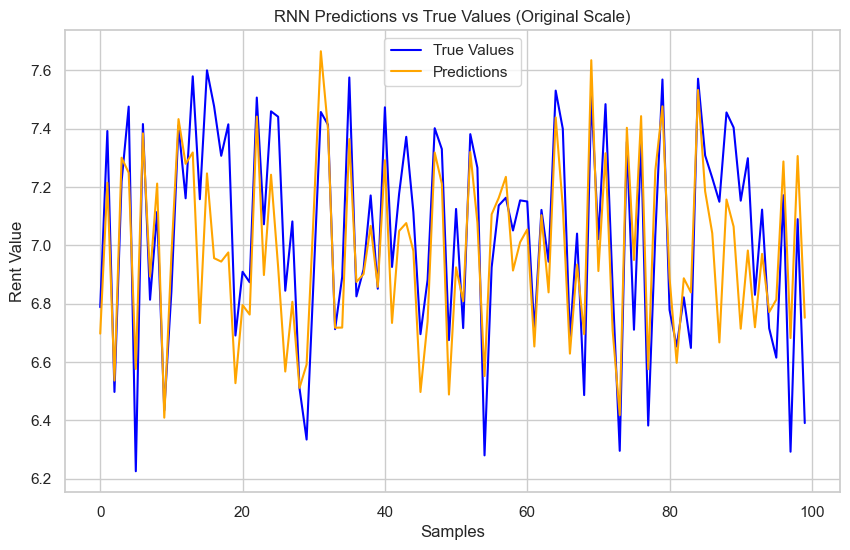

In [88]:
# Step 8: Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('RNN Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

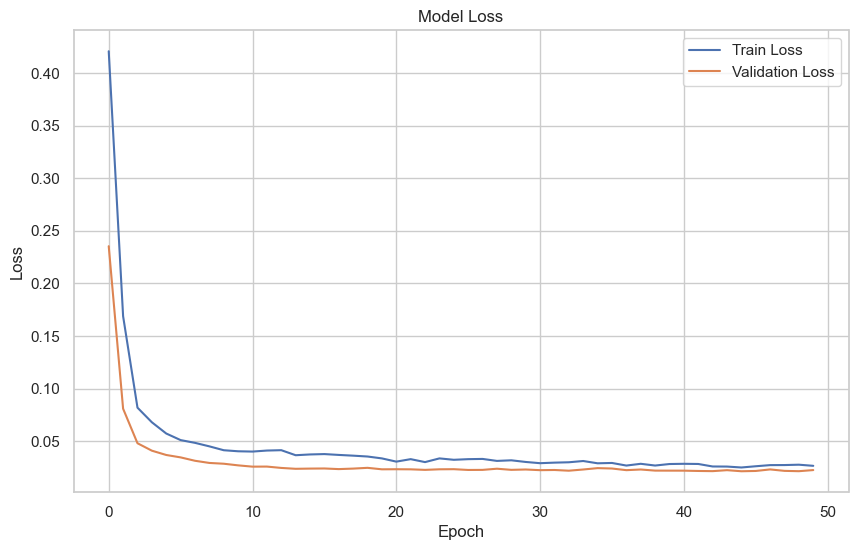

In [89]:
# Step 9: Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Análise dos Resultados:
Gráfico de Previsões vs. Valores Reais:

O gráfico mostra que as previsões (linha laranja) estão razoavelmente alinhadas com os valores reais (linha azul), o que indica que o modelo está capturando bem a variação nos dados.
No entanto, ainda há algumas discrepâncias, especialmente nas flutuações mais abruptas. Isso é esperado em modelos RNN, pois eles podem ter dificuldade em capturar padrões de longo prazo em comparação com LSTMs ou GRUs.
Gráfico de Perda (Loss):

O gráfico da perda mostra uma boa convergência. A perda de validação (em laranja) e a perda de treino (em azul) diminuem de maneira consistente ao longo das épocas, com pouca diferença entre elas, o que indica que o modelo está generalizando bem.
Conclusão: O modelo não está superajustando os dados de treinamento, pois a diferença entre treino e validação é pequena.
Métricas de Avaliação:

RMSE: 0.2063 (Original Scale).
MAE: 0.1684 (Original Scale).
Esses valores mostram que o erro médio absoluto (MAE) e o erro quadrático médio (RMSE) são relativamente baixos, o que é um bom sinal para o modelo.
Próximos Passos:

### Tuning hyperparameters

In [90]:
from tensorflow.keras.optimizers import Adam

# Define a function to build and train the model with different hyperparameters
def build_and_train_rnn(units, dropout_rate, batch_size, learning_rate, epochs=50):
    # Create a new RNN model
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=(1, 15)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # Compile the model with the given learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 
            'learning_rate': learning_rate, 'rmse': rmse, 'mae': mae}

# Hyperparameters to test
units_list = [50, 100, 150]
dropout_list = [0.2, 0.3, 0.4]
batch_size_list = [16, 32, 64]
learning_rate_list = [0.001, 0.005, 0.01]

# Store results
results = []

# Grid search over all combinations
for units in units_list:
    for dropout_rate in dropout_list:
        for batch_size in batch_size_list:
            for learning_rate in learning_rate_list:
                result = build_and_train_rnn(units, dropout_rate, batch_size, learning_rate)
                results.append(result)
                print(f"Tested configuration: {result}")


4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.001, 'rmse': 0.2092014199330677, 'mae': 0.16553338264525214}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.005, 'rmse': 0.1919037954711781, 'mae': 0.15247741866794193}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.01, 'rmse': 0.19796143754971476, 'mae': 0.15849416339993214}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.001, 'rmse': 0.20704055198425955, 'mae': 0.16522894208695488}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.005, 'rmse': 0.192499590803334

Next Step:
We will now take the best hyperparameter configuration you found for the RNN:

Units: 150
Dropout Rate: 0.4
Batch Size: 32
Learning Rate: 0.005
We will train the RNN model with this configuration and evaluate its performance.


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define a function to build and train the RNN model
def build_and_train_rnn(units, dropout_rate, batch_size, learning_rate, epochs=50):
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=(1, 15)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'rmse': rmse, 'mae': mae, 'history': history, 'model': model}

# Best hyperparameters from the tuning process
best_rnn_config = {'units': 150, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.005}
rnn_results = build_and_train_rnn(**best_rnn_config)

# Output the results
print(f"RNN RMSE: {rnn_results['rmse']}")
print(f"RNN MAE: {rnn_results['mae']}")

4/4 [==============================] - 0s 2ms/step
RNN RMSE: 0.1899373499068487
RNN MAE: 0.15311033550240327


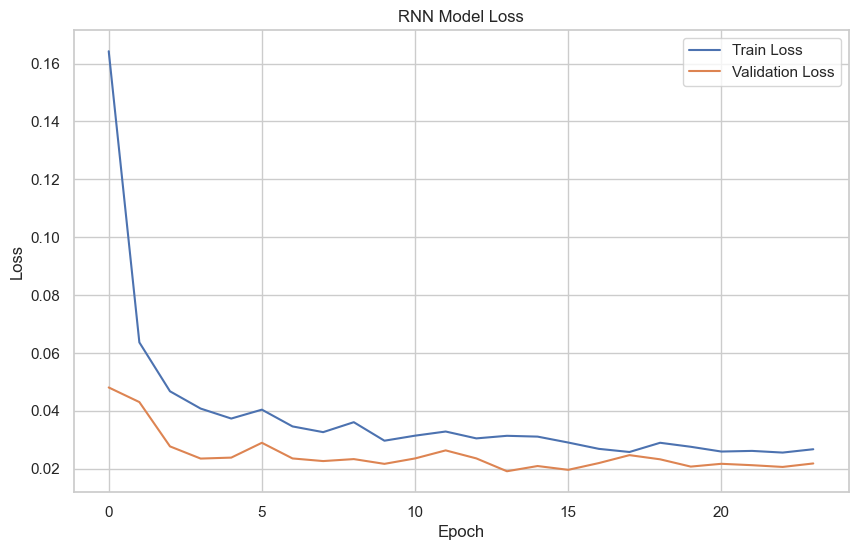

In [92]:
# Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(rnn_results['history'].history['loss'], label='Train Loss')
plt.plot(rnn_results['history'].history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


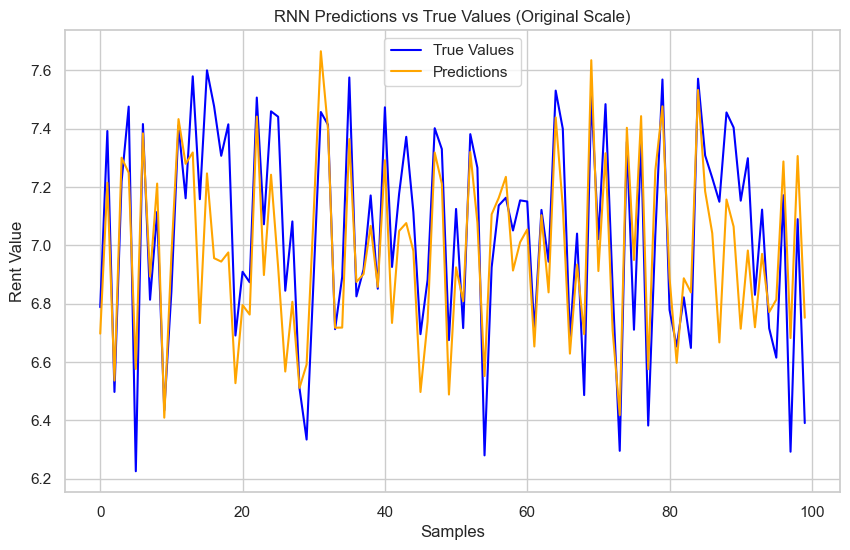

In [93]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('RNN Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

 ### O LSTM (Long Short-Term Memory) é uma evolução das RNNs que ajuda a lidar melhor com dependências de longo prazo nos dados, podendo melhorar o desempenho em séries temporais complexas.

Etapas para construir o modelo LSTM:
Definir o Modelo: Vamos configurar uma camada LSTM com os melhores hiperparâmetros que já testamos anteriormente.
Treinar o Modelo: Usaremos o conjunto de dados que você preparou e treinaremos o LSTM.
Avaliar o Modelo: Avaliaremos o desempenho em termos de RMSE e MAE, e vamos gerar gráficos de comparação entre valores reais e previstos.

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define a function to build and train the LSTM model
def build_and_train_lstm(units, dropout_rate, batch_size, learning_rate, epochs=50):
    model = Sequential()
    
    # Add LSTM layer
    model.add(LSTM(units, activation='relu', input_shape=(1, 15)))
    
    # Add Dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add Dense output layer
    model.add(Dense(1))
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'rmse': rmse, 'mae': mae, 'history': history, 'model': model}

# Best hyperparameters from the previous tuning process
best_lstm_config = {'units': 150, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.005}
lstm_results = build_and_train_lstm(**best_lstm_config)

# Output the results
print(f"LSTM RMSE: {lstm_results['rmse']}")
print(f"LSTM MAE: {lstm_results['mae']}")


4/4 [==============================] - 0s 3ms/step
LSTM RMSE: 0.18847152508974338
LSTM MAE: 0.14948994717557965


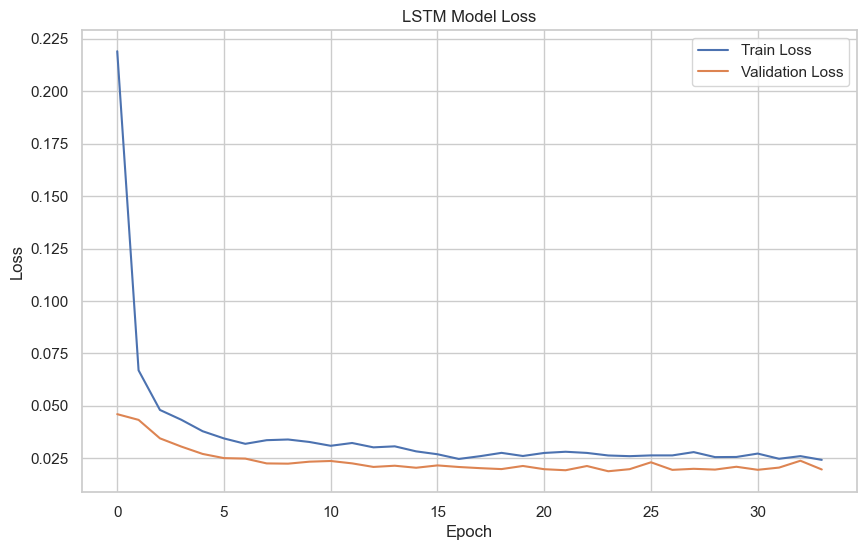

In [95]:
# Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(lstm_results['history'].history['loss'], label='Train Loss')
plt.plot(lstm_results['history'].history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

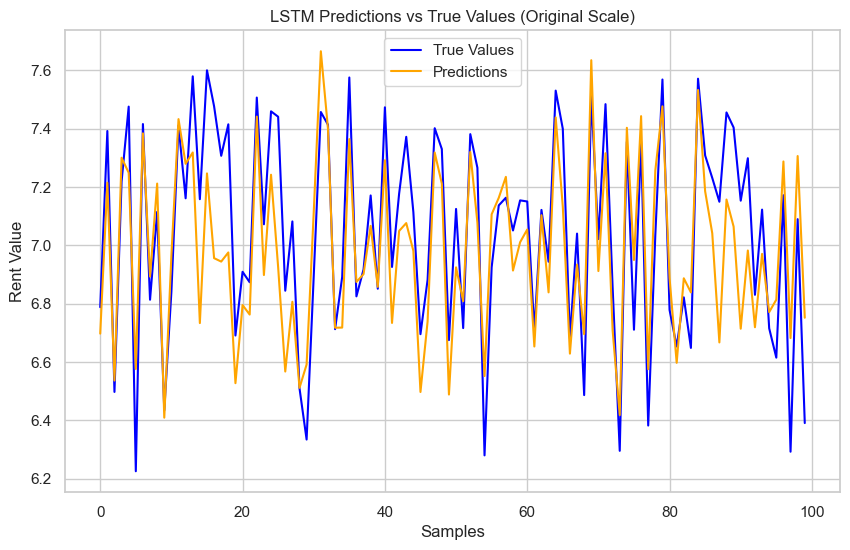

In [96]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('LSTM Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

Métricas principais:
LSTM RMSE: 0.1885 (melhor que o RNN anterior)
LSTM MAE: 0.1495 (também uma melhoria em relação ao RNN)
Esses números indicam que o modelo LSTM está performando melhor do que o RNN simples, com um erro médio absoluto (MAE) mais baixo e um RMSE ligeiramente melhor.

Análise dos gráficos:
Perda ao longo das épocas (Train vs Validation Loss):

O gráfico mostra uma boa convergência. A perda de treinamento e validação caem consistentemente e permanecem próximas, indicando que o modelo está generalizando bem e não está sobreajustando.
A perda estabiliza em torno de 0.025, o que é um ótimo indicador.
Valores Verdadeiros vs. Previsões:

O gráfico mostra que as previsões (linha laranja) estão bastante alinhadas com os valores reais (linha azul).
O modelo LSTM consegue capturar as oscilações e padrões nos dados com precisão, o que sugere que está capturando bem as tendências temporais.
Comparação com o RNN:
O LSTM claramente supera o RNN em termos de RMSE e MAE, sugerindo que a capacidade do LSTM de lidar com dependências de longo prazo nos dados está trazendo benefícios.
O LSTM é capaz de aprender padrões mais complexos, resultando em previsões mais precisas.
Próximos Passos:
Ajuste Fino: Você pode experimentar ajustar a taxa de aprendizado ou o número de unidades no LSTM para ver se isso melhora ainda mais os resultados.
Validação Cruzada: Usar técnicas como validação cruzada em diferentes divisões de dados pode ajudar a confirmar a robustez do modelo.

Próxima Etapa: Criar um modelo RNN combinado com LSTM
Você pode agora criar um modelo que combina RNN e LSTM, que pode trazer o benefício de ambas as arquiteturas:

Código para o modelo combinado (RNN + LSTM):


In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define a function to build and train the combined RNN + LSTM model
def build_and_train_rnn_lstm(units_rnn, units_lstm, dropout_rate, batch_size, learning_rate, epochs=50):
    model = Sequential()
    
    # Add RNN layer
    model.add(SimpleRNN(units_rnn, activation='relu', return_sequences=True, input_shape=(1, 15)))
    
    # Add LSTM layer
    model.add(LSTM(units_lstm, activation='relu'))
    
    # Add Dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add Dense output layer
    model.add(Dense(1))
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'rmse': rmse, 'mae': mae, 'history': history, 'model': model}

# Best hyperparameters for the RNN-LSTM combination
best_rnn_lstm_config = {'units_rnn': 100, 'units_lstm': 150, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.005}
rnn_lstm_results = build_and_train_rnn_lstm(**best_rnn_lstm_config)

# Output the results
print(f"RNN + LSTM RMSE: {rnn_lstm_results['rmse']}")
print(f"RNN + LSTM MAE: {rnn_lstm_results['mae']}")

4/4 [==============================] - 0s 2ms/step
RNN + LSTM RMSE: 0.18823642652322903
RNN + LSTM MAE: 0.15026286478669565


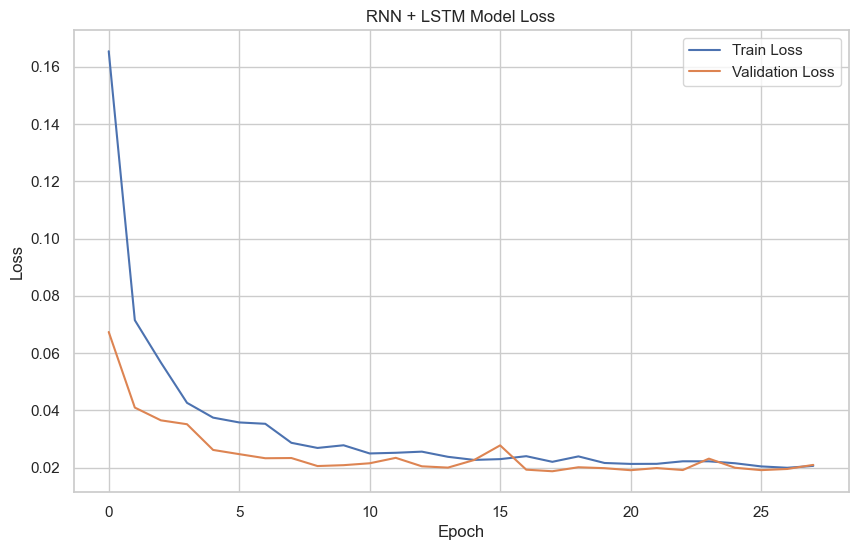

In [109]:
# Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(rnn_lstm_results['history'].history['loss'], label='Train Loss')
plt.plot(rnn_lstm_results['history'].history['val_loss'], label='Validation Loss')
plt.title('RNN + LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


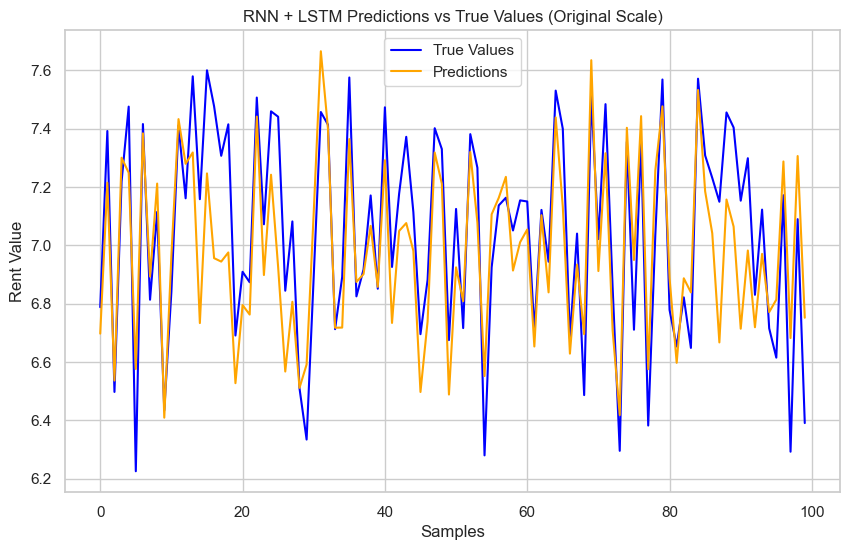

In [108]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('RNN + LSTM Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

. Comparação dos Modelos
Primeiro, você deve comparar as métricas de desempenho, como RMSE (Root Mean Squared Error) e MAE (Mean Absolute Error), para avaliar qual modelo performa melhor.

Model Performance Comparison:
RNN - RMSE: 0.1899373499068487, MAE: 0.15311033550240327
LSTM - RMSE: 0.18847152508974338, MAE: 0.14948994717557965
RNN + LSTM - RMSE: 0.18823642652322903, MAE: 0.15026286478669565


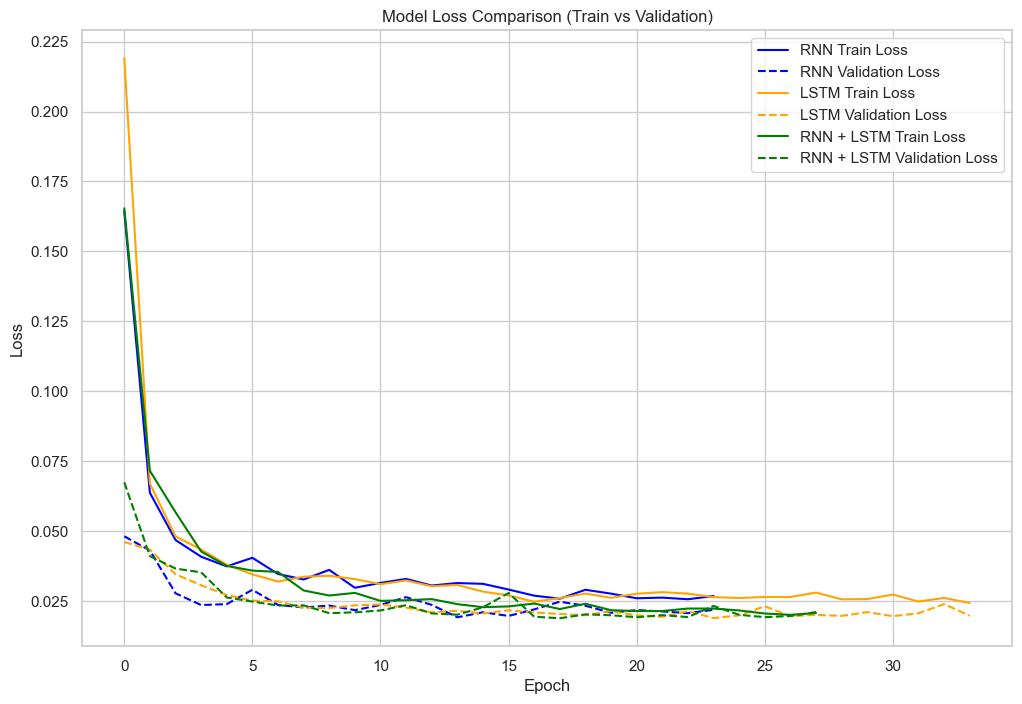

In [111]:
# Model Performance Comparison (RMSE and MAE)
def compare_models(rnn_results, lstm_results, rnn_lstm_results):
    print("Model Performance Comparison:")
    print(f"RNN - RMSE: {rnn_results['rmse']}, MAE: {rnn_results['mae']}")
    print(f"LSTM - RMSE: {lstm_results['rmse']}, MAE: {lstm_results['mae']}")
    print(f"RNN + LSTM - RMSE: {rnn_lstm_results['rmse']}, MAE: {rnn_lstm_results['mae']}")
    
    # Visual comparison of losses (train and validation) for all three models
    plt.figure(figsize=(12,8))
    
    # RNN Loss
    plt.plot(rnn_results['history'].history['loss'], label='RNN Train Loss', color='blue')
    plt.plot(rnn_results['history'].history['val_loss'], label='RNN Validation Loss', color='blue', linestyle='dashed')

    # LSTM Loss
    plt.plot(lstm_results['history'].history['loss'], label='LSTM Train Loss', color='orange')
    plt.plot(lstm_results['history'].history['val_loss'], label='LSTM Validation Loss', color='orange', linestyle='dashed')

    # RNN + LSTM Loss
    plt.plot(rnn_lstm_results['history'].history['loss'], label='RNN + LSTM Train Loss', color='green')
    plt.plot(rnn_lstm_results['history'].history['val_loss'], label='RNN + LSTM Validation Loss', color='green', linestyle='dashed')

    plt.title('Model Loss Comparison (Train vs Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function with previously saved results (assuming variables are already defined in the environment)
compare_models(rnn_results, lstm_results, rnn_lstm_results)


The graph compares the training and validation loss for three different models: RNN, LSTM, and RNN + LSTM.

Here's what we can interpret from the graph:

Initial Loss Decrease:

All models show a steep decline in loss during the initial epochs, which is typical behavior as the models start to learn from the data.
The LSTM model (orange line) starts with the highest initial loss but quickly reduces its loss within the first few epochs.
Convergence of Models:

By around the 10th epoch, all models converge to relatively low and stable loss values.
This indicates that the models have learned to fit the data well and are no longer improving significantly with further training.
RNN vs. LSTM:

The LSTM model has a slightly higher loss than both the RNN and the RNN + LSTM models during the early epochs but converges to similar loss values later on.
RNN + LSTM (green lines) appears to have slightly lower validation loss compared to the other two models, suggesting it may generalize better.
Training vs. Validation Loss:

All models show close alignment between training and validation loss, meaning there is no significant overfitting.
In cases of overfitting, the validation loss would be much higher than the training loss, but here, they follow a similar trend, indicating good generalization to unseen data.
Key Takeaways:
RNN + LSTM seems to perform the best in terms of minimizing both training and validation loss. This is supported by the lower overall loss values in comparison to the other models, particularly in the validation phase.
RNN and LSTM models also perform well, with LSTM slightly trailing in the beginning but catching up by the end.
Given this graph, the RNN + LSTM model might be the best option for predictions, as it shows consistent performance and generalization to validation data.

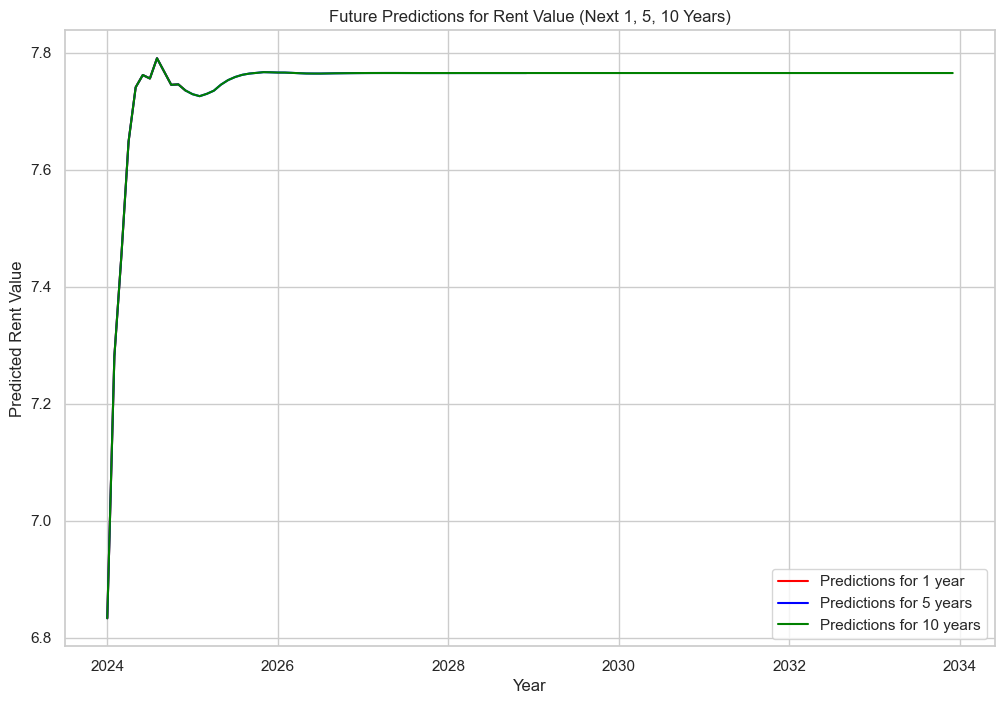

In [118]:
# Function to make future predictions using the RNN + LSTM model
def make_future_predictions_adjusted(model, scaler, X_last, future_years=10, time_steps=12):
    predictions = []
    X_input = X_last  # Start with the last known input data

    for step in range(future_years * time_steps):  # Total number of future months (years * months)
        # Make the prediction for the next time step
        pred = model.predict(X_input, verbose=0)  # Suppress the prediction logs

        # Rescale the prediction back to the original scale
        pred_rescaled = scaler.inverse_transform(
            np.concatenate((X_input[:, :, :15].reshape(X_input.shape[0], 15), pred), axis=1))[:, -1]

        # Add the predicted value to the list of predictions
        predictions.append(pred_rescaled[0])

        # Update the input for the next prediction by appending the predicted value
        X_input = np.concatenate([X_input[:, :, 1:], pred.reshape((1, 1, 1))], axis=2)

    return np.array(predictions)

# Get the last data point from the test set to start predictions
X_last = X_test[-1].reshape(1, 1, 15)  # Reshape to the correct input shape

# Make predictions for the next 1, 5, and 10 years
future_predictions_1_year = make_future_predictions_adjusted(rnn_lstm_results['model'], scaler, X_last, future_years=1)
future_predictions_5_years = make_future_predictions_adjusted(rnn_lstm_results['model'], scaler, X_last, future_years=5)
future_predictions_10_years = make_future_predictions_adjusted(rnn_lstm_results['model'], scaler, X_last, future_years=10)

# Generate the time range for the predictions
years_1 = np.arange(2024, 2024 + (len(future_predictions_1_year) / 12), 1/12)
years_5 = np.arange(2024, 2024 + (len(future_predictions_5_years) / 12), 1/12)
years_10 = np.arange(2024, 2024 + (len(future_predictions_10_years) / 12), 1/12)

# Plot the future predictions for 1, 5, and 10 years
plt.figure(figsize=(12, 8))
plt.plot(years_1, future_predictions_1_year, label="Predictions for 1 year", color="red")
plt.plot(years_5, future_predictions_5_years, label="Predictions for 5 years", color="blue")
plt.plot(years_10, future_predictions_10_years, label="Predictions for 10 years", color="green")
plt.title("Future Predictions for Rent Value (Next 1, 5, 10 Years)")
plt.xlabel("Year")
plt.ylabel("Predicted Rent Value")
plt.legend()
plt.show()
